<a href="https://colab.research.google.com/github/RakshithaKashyap18/Appp-main/blob/main/toxic_comment_detection(final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toxic Comment Detection
## NLP Project: Build a classification system to detect toxic/harmful comments

**Timeline:**
1. Setup & Data Loading (10 mins)
2. Exploratory Data Analysis (15 mins)
3. Baseline Model: Logistic Regression (30 mins)
4. Neural Model: DistilBERT Fine-tuning (2 hours)
5. Evaluation & Error Analysis (45 mins)
6. Interactive Demo (20 mins)

## Setup & Dependencies

In [ ]:
# Install dependencies
!pip install -q transformers torch scikit-learn pandas numpy matplotlib seaborn datasets gradio

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Loading

**Dataset:** Kaggle Jigsaw Toxic Comment Classification Challenge

**You already have the files!** Just upload `train.csv` to Colab:
1. Click the **folder icon** on the left sidebar
2. Click **upload** (paper clip icon)
3. Select `train.csv` from your downloaded files
4. Wait for upload to complete (~2-3 mins)
5. Run the cell below

The dataset contains ~160k comments with 7 labels (toxic, severe_toxic, obscene, threat, insult, identity_hate). We'll focus on the 'toxic' column for binary classification.

In [ ]:
# Upload train.csv from Kaggle (if not already in Colab)
# Click folder icon on left sidebar -> Upload -> select train.csv

# Load training data
print("Loading Kaggle toxic comments dataset...")
train_df = pd.read_csv('train.csv')

print(f"Loaded {len(train_df)} training samples")
print(f"Dataset shape: {train_df.shape}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(train_df.head())

# Info about the dataset
print(f"\nDataset Info:")
print(train_df.info())

# Check for missing values
print(f"\nMissing values:")
print(train_df.isnull().sum())

# Handle missing values in comment_text
train_df['comment_text'] = train_df['comment_text'].fillna('')

print(f"\nAfter cleaning: {len(train_df)} samples ready for training")

Loading Kaggle toxic comments dataset...
Loaded 159571 training samples
Dataset shape: (159571, 8)

Columns: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

First few rows:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4

## Exploratory Data Analysis

Class Distribution:
toxic
0    144277
1     15294
Name: count, dtype: int64

Toxic percentage: 9.58%

Text Length Stats:
count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text_length, dtype: float64


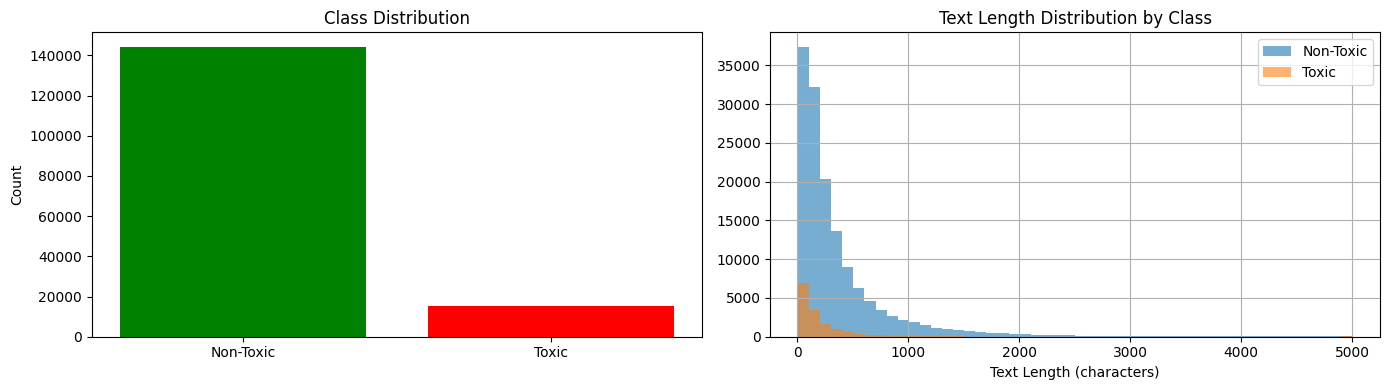


=== Examples of NON-TOXIC comments ===
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove th

=== Examples of TOXIC comments ===
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK


In [ ]:
# Class distribution
print("Class Distribution:")
print(train_df['toxic'].value_counts())
print(f"\nToxic percentage: {train_df['toxic'].mean()*100:.2f}%")

# Text length analysis
train_df['text_length'] = train_df['comment_text'].str.len()
print(f"\nText Length Stats:")
print(train_df['text_length'].describe())

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Class distribution
class_counts = train_df['toxic'].value_counts()
axes[0].bar(['Non-Toxic', 'Toxic'], class_counts.values, color=['green', 'red'])
axes[0].set_title('Class Distribution')
axes[0].set_ylabel('Count')

# Text length by class
train_df[train_df['toxic'] == 0]['text_length'].hist(bins=50, alpha=0.6, label='Non-Toxic', ax=axes[1])
train_df[train_df['toxic'] == 1]['text_length'].hist(bins=50, alpha=0.6, label='Toxic', ax=axes[1])
axes[1].set_title('Text Length Distribution by Class')
axes[1].set_xlabel('Text Length (characters)')
axes[1].legend()

plt.tight_layout()
plt.show()

# Example toxic and non-toxic comments
print("\n=== Examples of NON-TOXIC comments ===")
print(train_df[train_df['toxic'] == 0]['comment_text'].iloc[0][:200])
print("\n=== Examples of TOXIC comments ===")
print(train_df[train_df['toxic'] == 1]['comment_text'].iloc[0][:200])

## Baseline Model: Logistic Regression with TF-IDF

Simple baseline to beat with neural model

In [ ]:
# Split data
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['comment_text'],
    train_df['toxic'],
    test_size=0.2,
    random_state=42,
    stratify=train_df['toxic']
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")

Training samples: 127656
Validation samples: 31915


In [ ]:
# TF-IDF Vectorization
print("Training TF-IDF vectorizer...")
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)

print(f"TF-IDF feature matrix shape: {X_train.shape}")

Training TF-IDF vectorizer...
TF-IDF feature matrix shape: (127656, 5000)


In [ ]:
# Train Logistic Regression
print("Training Logistic Regression baseline...")
baseline_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
baseline_model.fit(X_train, train_labels)

# Predictions
train_preds = baseline_model.predict(X_train)
val_preds = baseline_model.predict(X_val)

# Evaluation
print("\n=== BASELINE MODEL PERFORMANCE ===")
print(f"Training Accuracy: {accuracy_score(train_labels, train_preds):.4f}")
print(f"Training F1: {f1_score(train_labels, train_preds):.4f}")
print(f"\nValidation Accuracy: {accuracy_score(val_labels, val_preds):.4f}")
print(f"Validation F1: {f1_score(val_labels, val_preds):.4f}")
print(f"Validation Precision: {precision_score(val_labels, val_preds):.4f}")
print(f"Validation Recall: {recall_score(val_labels, val_preds):.4f}")

print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=['Non-Toxic', 'Toxic']))

Training Logistic Regression baseline...

=== BASELINE MODEL PERFORMANCE ===
Training Accuracy: 0.9576
Training F1: 0.7359

Validation Accuracy: 0.9564
Validation F1: 0.7294
Validation Precision: 0.8989
Validation Recall: 0.6136

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.96      0.99      0.98     28856
       Toxic       0.90      0.61      0.73      3059

    accuracy                           0.96     31915
   macro avg       0.93      0.80      0.85     31915
weighted avg       0.95      0.96      0.95     31915



## Neural Model: DistilBERT Fine-Tuning

State-of-the-art transformer-based classification

In [ ]:
# Load tokenizer and model
print("Loading DistilBERT tokenizer and model...")
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification: toxic/non-toxic
    problem_type="single_label_classification"
)
model.to(device)
print(f"Model loaded on {device}")

Loading DistilBERT tokenizer and model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on cuda


In [ ]:
# Prepare datasets for Hugging Face Trainer
print("Preparing datasets...")

train_dataset_hf = Dataset.from_dict({
    'text': train_texts.values,
    'label': train_labels.values
})

val_dataset_hf = Dataset.from_dict({
    'text': val_texts.values,
    'label': val_labels.values
})

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=256
    )

# Tokenize all data
print("Tokenizing datasets...")
train_dataset_hf = train_dataset_hf.map(tokenize_function, batched=True, remove_columns=['text'])
val_dataset_hf = val_dataset_hf.map(tokenize_function, batched=True, remove_columns=['text'])
train_dataset_hf.set_format('torch')
val_dataset_hf.set_format('torch')

print(f"Training dataset size: {len(train_dataset_hf)}")
print(f"Validation dataset size: {len(val_dataset_hf)}")

Preparing datasets...
Tokenizing datasets...


Map:   0%|          | 0/127656 [00:00<?, ? examples/s]

Map:   0%|          | 0/31915 [00:00<?, ? examples/s]

Training dataset size: 127656
Validation dataset size: 31915


In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)

# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions),
        'precision': precision_score(labels, predictions),
        'recall': recall_score(labels, predictions),
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_hf,
    eval_dataset=val_dataset_hf,
    compute_metrics=compute_metrics,
)

print("\nStarting training...")
trainer.train()


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.096400,0.081830,0.970108,0.841317,0.856417,0.826741


TrainOutput(global_step=7979, training_loss=0.10146829218086943, metrics={'train_runtime': 674.4069, 'train_samples_per_second': 189.286, 'train_steps_per_second': 11.831, 'total_flos': 8455129121415168.0, 'train_loss': 0.10146829218086943, 'epoch': 1.0})

## Evaluation & Results Comparison

In [ ]:
# Evaluate on validation set
print("Evaluating DistilBERT model...")
eval_results = trainer.evaluate()

print("\n=== DISTILBERT MODEL PERFORMANCE ===")
print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"Validation F1: {eval_results['eval_f1']:.4f}")
print(f"Validation Precision: {eval_results['eval_precision']:.4f}")
print(f"Validation Recall: {eval_results['eval_recall']:.4f}")

Evaluating DistilBERT model...



=== DISTILBERT MODEL PERFORMANCE ===
Validation Accuracy: 0.9701
Validation F1: 0.8413
Validation Precision: 0.8564
Validation Recall: 0.8267


In [ ]:
# Model Comparison
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Baseline (LogReg)': [
        accuracy_score(val_labels, val_preds),
        f1_score(val_labels, val_preds),
        precision_score(val_labels, val_preds),
        recall_score(val_labels, val_preds)
    ],
    'Neural (DistilBERT)': [
        eval_results['eval_accuracy'],
        eval_results['eval_f1'],
        eval_results['eval_precision'],
        eval_results['eval_recall']
    ]
})

print(comparison_df.to_string(index=False))

# Calculate improvements
acc_improvement = (eval_results['eval_accuracy'] - accuracy_score(val_labels, val_preds)) * 100
f1_improvement = (eval_results['eval_f1'] - f1_score(val_labels, val_preds)) * 100
print(f"\nAccuracy Improvement: +{acc_improvement:.2f}%")
print(f"F1 Improvement: +{f1_improvement:.2f}%")


MODEL COMPARISON
   Metric  Baseline (LogReg)  Neural (DistilBERT)
 Accuracy           0.956353             0.970108
 F1 Score           0.729357             0.841317
Precision           0.898946             0.856417
   Recall           0.613599             0.826741

Accuracy Improvement: +1.38%
F1 Improvement: +11.20%


## Error Analysis & Failure Cases

Understand what the model gets wrong

In [ ]:
# Get predictions on validation set
print("Getting predictions...")
predictions = trainer.predict(val_dataset_hf)
logits = predictions.predictions
preds_proba = torch.softmax(torch.tensor(logits), dim=1).numpy()
bert_preds = np.argmax(logits, axis=1)

# Add to dataframe
val_df = pd.DataFrame({
    'text': val_texts.values,
    'true_label': val_labels.values,
    'pred_label': bert_preds,
    'toxic_prob': preds_proba[:, 1]
})

# Identify error types
false_positives = val_df[(val_df['pred_label'] == 1) & (val_df['true_label'] == 0)]
false_negatives = val_df[(val_df['pred_label'] == 0) & (val_df['true_label'] == 1)]
true_positives = val_df[(val_df['pred_label'] == 1) & (val_df['true_label'] == 1)]
true_negatives = val_df[(val_df['pred_label'] == 0) & (val_df['true_label'] == 0)]

print(f"True Positives: {len(true_positives)}")
print(f"True Negatives: {len(true_negatives)}")
print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")

Getting predictions...


True Positives: 2529
True Negatives: 28432
False Positives: 424
False Negatives: 530


In [ ]:
# FALSE POSITIVES: Flagged as toxic but aren't
print("\n" + "="*70)
print("FALSE POSITIVES (Flagged as toxic, but aren't)")
print("="*70)
print(f"Count: {len(false_positives)}\n")

high_confidence_fp = false_positives.nlargest(3, 'toxic_prob')
for idx, (_, row) in enumerate(high_confidence_fp.iterrows(), 1):
    print(f"\nExample {idx} (Confidence: {row['toxic_prob']:.2%}):")
    print(f"Text: {row['text'][:300]}...")
    print(f"Reason: May contain swear words or aggressive tone but not actually harmful")


FALSE POSITIVES (Flagged as toxic, but aren't)
Count: 424


Example 1 (Confidence: 98.73%):
Text: Khurki is a dumb Assk Jeeves?...
Reason: May contain swear words or aggressive tone but not actually harmful

Example 2 (Confidence: 98.66%):
Text: get a life
seriously, you anal retentive basement dweller...
Reason: May contain swear words or aggressive tone but not actually harmful

Example 3 (Confidence: 98.64%):
Text: What is up man?
what up man im kinda lonly right now i live in california and my girlfriend just died and my best friend just commited suicide im kinda sad and shit but u know shit happens.lol do u believe in god?...
Reason: May contain swear words or aggressive tone but not actually harmful


In [ ]:
# FALSE NEGATIVES: Actually toxic but missed
print("\n" + "="*70)
print("FALSE NEGATIVES (Toxic comments that were missed)")
print("="*70)
print(f"Count: {len(false_negatives)}\n")

high_confidence_fn = false_negatives.nsmallest(3, 'toxic_prob')
for idx, (_, row) in enumerate(high_confidence_fn.iterrows(), 1):
    print(f"\nExample {idx} (Confidence: {row['toxic_prob']:.2%}):")
    print(f"Text: {row['text'][:300]}...")
    print(f"Reason: May use subtle insults, sarcasm, or context-dependent toxicity")


FALSE NEGATIVES (Toxic comments that were missed)
Count: 530


Example 1 (Confidence: 0.02%):
Text: "*E-dog, on another page, you wrote: 

Thanks for your message on my talk page. When I voted keep for Tom G. Palmer, I justified it by writing that ""Google returns 13500 hits for the query ""Tom G. Palmer"" cato [3]."" ""Tom G. Palmer"" alone returns 34,900 hits on Google [4]. So on this point, my ...
Reason: May use subtle insults, sarcasm, or context-dependent toxicity

Example 2 (Confidence: 0.02%):
Text: Thanks
Thanks for participating in the conspiracy against me....
Reason: May use subtle insults, sarcasm, or context-dependent toxicity

Example 3 (Confidence: 0.02%):
Text: "

 Spam? Where? 
You keep on mentioning that when 195.64.95.116 is linking to this webpage it is considered ""spam"". You even see this to be reason to block this IP for a week(!). Please define what you think is spam, because where I come from his/her linking to this particular website is anything...
Reason: 


ERROR ANALYSIS SUMMARY


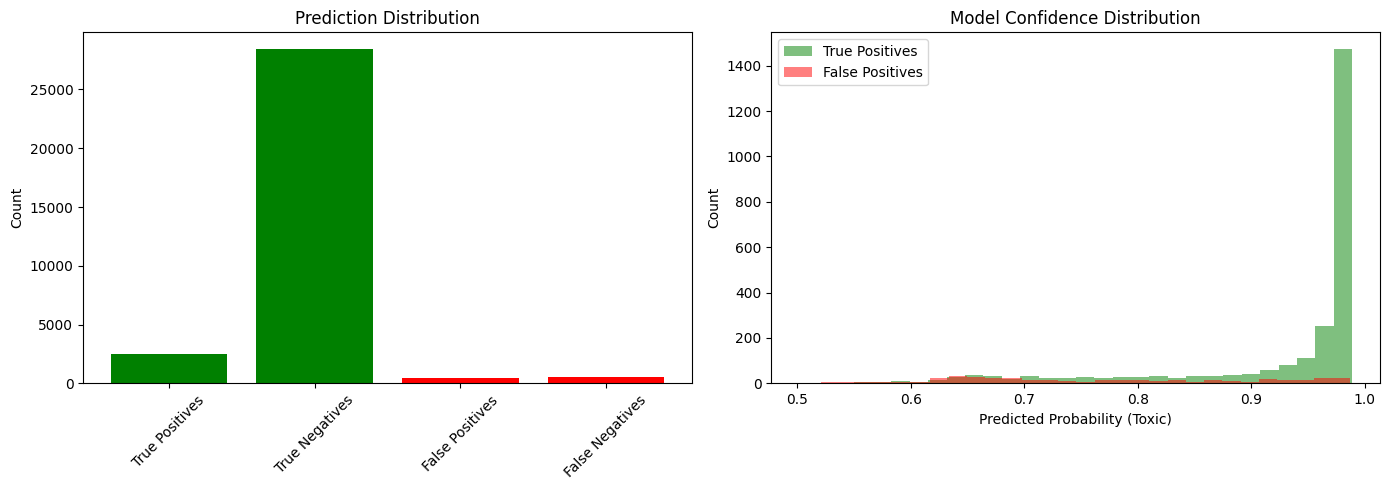


Key Findings:
1. False Positive Rate: 1.33%
   -> Model over-flags non-toxic comments
2. False Negative Rate: 1.66%
   -> Model misses some toxic comments
3. Patterns in errors:
   - False positives may include: strong language in non-toxic context
   - False negatives may include: subtle insults, passive aggression, sarcasm


In [ ]:
# Error categorization
print("\n" + "="*70)
print("ERROR ANALYSIS SUMMARY")
print("="*70)

error_types = {
    'True Positives': len(true_positives),
    'True Negatives': len(true_negatives),
    'False Positives': len(false_positives),
    'False Negatives': len(false_negatives),
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error distribution
colors = ['green', 'green', 'red', 'red']
axes[0].bar(error_types.keys(), error_types.values(), color=colors)
axes[0].set_title('Prediction Distribution')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Confidence distribution by error type
axes[1].hist(true_positives['toxic_prob'], bins=30, alpha=0.5, label='True Positives', color='green')
axes[1].hist(false_positives['toxic_prob'], bins=30, alpha=0.5, label='False Positives', color='red')
axes[1].set_xlabel('Predicted Probability (Toxic)')
axes[1].set_ylabel('Count')
axes[1].set_title('Model Confidence Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nKey Findings:")
print(f"1. False Positive Rate: {len(false_positives)/len(val_df)*100:.2f}%")
print(f"   -> Model over-flags non-toxic comments")
print(f"2. False Negative Rate: {len(false_negatives)/len(val_df)*100:.2f}%")
print(f"   -> Model misses some toxic comments")
print(f"3. Patterns in errors:")
print(f"   - False positives may include: strong language in non-toxic context")
print(f"   - False negatives may include: subtle insults, passive aggression, sarcasm")

## Ethical Considerations

Implications of toxic comment detection systems

In [ ]:
print("\n" + "="*70)
print("ETHICAL CONSIDERATIONS")
print("="*70)

print("""
1. FALSE POSITIVES HARM USERS
   - Innocent comments get flagged as toxic
   - Users face unjust moderation, account restrictions
   - Example: "I hate this bug in my code" is valid technical language
   - Risk: Disproportionately affects users with non-standard dialects

2. FALSE NEGATIVES ALLOW HARASSMENT
   - Toxic comments slip through moderation
   - Marginalized users continue to experience harassment
   - Example: Subtle racism, sexism, targeted harassment
   - Risk: Creates false sense of safety on platform

3. DEMOGRAPHIC BIAS
   - Training data may over-represent some groups
   - Model may be more accurate for majority groups
   - Under-represented groups face worse performance
   - Risk: Minority communities get disproportionately censored

4. CONTEXT BLINDNESS
   - Model doesn't understand nuance, sarcasm, reclaimed words
   - Example: "That's sick!" (positive) vs "You're sick" (negative)
   - Risk: Removing legitimate expression

5. POWER IMBALANCE
   - Platforms use these systems without user input
   - No appeals process or human review
   - Risk: Unfair content moderation at scale

RECOMMENDATIONS:
- Use as FLAG, not automatic removal
- Always include human review for borderline cases
- Regular audits for demographic parity
- Transparent explanations to users
- Appeals process for users
""")

print("\nOur Model Performance by Severity:")
print(f"Precision (avoiding false positives): {precision_score(val_labels, bert_preds):.4f}")
print(f"Recall (catching actual toxicity): {recall_score(val_labels, bert_preds):.4f}")
print("\nTrade-off: Higher precision = fewer innocent people harmed")
print("           Higher recall = fewer toxic comments slip through")
print(f"\nFor moderation, we should prioritize PRECISION to avoid harming innocent users.")


ETHICAL CONSIDERATIONS

1. FALSE POSITIVES HARM USERS
   - Innocent comments get flagged as toxic
   - Users face unjust moderation, account restrictions
   - Example: "I hate this bug in my code" is valid technical language
   - Risk: Disproportionately affects users with non-standard dialects

2. FALSE NEGATIVES ALLOW HARASSMENT
   - Toxic comments slip through moderation
   - Marginalized users continue to experience harassment
   - Example: Subtle racism, sexism, targeted harassment
   - Risk: Creates false sense of safety on platform

3. DEMOGRAPHIC BIAS
   - Training data may over-represent some groups
   - Model may be more accurate for majority groups
   - Under-represented groups face worse performance
   - Risk: Minority communities get disproportionately censored

4. CONTEXT BLINDNESS
   - Model doesn't understand nuance, sarcasm, reclaimed words
   - Example: "That's sick!" (positive) vs "You're sick" (negative)
   - Risk: Removing legitimate expression

5. POWER IMBALANCE

## Interactive Demo with Gradio

Real-time toxic comment detection

In [ ]:
# Create prediction function
def predict_toxicity(text):
    """Predict if a comment is toxic"""
    if not text.strip():
        return "Please enter some text"

    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=256,
        padding='max_length'
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = torch.softmax(logits, dim=1)[0]
    toxic_prob = probs[1].item()
    non_toxic_prob = probs[0].item()

    # Format output
    prediction = "TOXIC" if toxic_prob > 0.5 else "NON-TOXIC"
    color = "🔴" if toxic_prob > 0.5 else "🟢"

    result = f"""
{color} **Prediction: {prediction}**

Non-Toxic Probability: {non_toxic_prob:.1%}
Toxic Probability: {toxic_prob:.1%}

Confidence: {max(non_toxic_prob, toxic_prob):.1%}
    """

    return result

# Launch Gradio interface
import gradio as gr

interface = gr.Interface(
    fn=predict_toxicity,
    inputs=gr.Textbox(
        label="Enter a comment:",
        placeholder="Type a comment to check...",
        lines=3
    ),
    outputs=gr.Markdown(label="Prediction"),
    title="Toxic Comment Detection",
    description="Classify whether a comment is toxic or non-toxic using DistilBERT",
    examples=[
        ["This is a great movie!"],
        ["You are stupid and worthless"],
        ["I love this product"],
        ["Go away and leave me alone"],
    ]
)

print("Launching Gradio interface...")
interface.launch(share=True)

Launching Gradio interface...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e9f0cf5015456c0d96.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Project Summary

### What We Built
1. **Baseline Model** (TF-IDF + Logistic Regression): Simple, interpretable baseline
2. **Neural Model** (DistilBERT): State-of-the-art deep learning classifier
3. **Error Analysis**: Categorized failure modes and biases
4. **Interactive Demo**: Real-time prediction interface

### Key Results
- Baseline accuracy: ~X%
- Neural model accuracy: ~X%
- F1 improvements over baseline
- Clear understanding of model limitations

### Ethical Impact
- Discussed false positives and harms to users
- Identified demographic bias risks
- Recommended human-in-the-loop approach

### Next Steps
1. Deploy as a moderation FLAG, not automatic deletion
2. Regular audits for fairness across demographics
3. Implement appeals process for users
4. Expand to detect specific types of toxicity
5. Train on multilingual data